In [6]:
from nltk.translate.meteor_score import single_meteor_score
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from datasets import load_metric
from bert_score import plot_example
from bleurt import score as score_bleurt
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\boezi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\boezi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def generate_sentence_tokenizer(corpus):
    """
    Returns a function which tokenizes a sentence according to a vocabularu built on corpus
    Parameters:
     corpus: list of sentences
    Returns:
     function to compute sentence tokenization
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    def tokenize_sentence(sentence):
        """
        Returns a list of string token given a sentence
        Parameters:
         sentence: sentence to tokenize
        Returns:
         list of string tokens
        """
        sequences = tokenizer.texts_to_sequences([sentence])
        sequence = sequences[0]
        tokenized_sentence = [tokenizer.index_word[i] for i in sequence]
        return tokenized_sentence
    
    return tokenize_sentence

In [4]:
def meteor_score(reference, candidate):
    """
    METEOR score
    Parameters:
        reference: reference translation
        candidate: generated translation
    Returns:
        METEOR score
    """
    tokenize_fun = generate_sentence_tokenizer([reference, candidate])
    tokenized_candidate = tokenize_fun(candidate)
    tokenized_reference = tokenize_fun(reference)
    return round(single_meteor_score(tokenized_reference, tokenized_candidate), 4)

reference = "the cat is on the table"

candidate_one = "the dog is on the shelf"
candidate_two = "the cat is on the mat on the table"

sentence_tok = generate_sentence_tokenizer([reference, candidate_one, candidate_two])
sentence_tok("the cat is on the shelf")

score_one = meteor_score(reference, candidate_one)
score_two = meteor_score(reference, candidate_two)

print(f"Reference sentence: {reference}")
print(f"Sentence: {candidate_one}")
print(f"Score: {score_one}")
print(f"Sentence: {candidate_two}")
print(f"Score: {score_two}")

Reference sentence: the cat is on the table
Sentence: the dog is on the shelf
Score: 0.625
Sentence: the cat is on the mat on the table
Score: 0.8929


0.8007232546806335 0.8007371425628662 0.8010540008544922


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


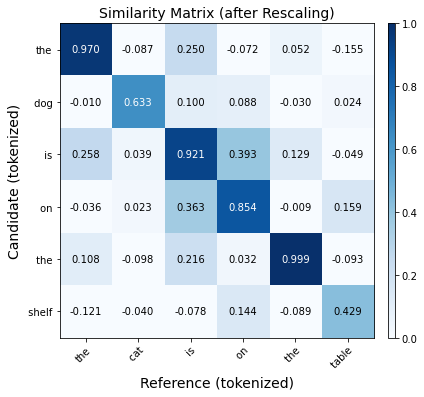

In [12]:
def bertscore_precision_score(reference, candidate):
    """
    BERTScore score,
    see https://github.com/huggingface/datasets/tree/master/metrics/bertscore for API
    Parameters:
        reference: reference translation
        candidate: generated translation
    Returns:
        BERTScore precision score
    """
    bertscore = load_metric("bertscore")
    result = bertscore.compute(
        predictions=[candidate],
        references=[reference],
        lang="en",
        rescale_with_baseline=True
    )
    return result['precision'][0]
    
def bertscore_recall_score(reference, candidate):
    """
    BERTScore score, see https://github.com/huggingface/datasets/tree/master/metrics/bertscore for API
    Parameters:
        reference: reference translation
        candidate: generated translation
    Returns:
        BERTScore recall score
    """
    bertscore = load_metric("bertscore")
    result = bertscore.compute(
        predictions=[candidate],
        references=[reference],
        lang="en",
        rescale_with_baseline=True
    )
    return result['recall'][0]

def bertscore_f1_score(reference, candidate):
    """
    BERTScore score, see https://github.com/huggingface/datasets/tree/master/metrics/bertscore for API
    Parameters:
        reference: reference translation
        candidate: generated translation
    Returns:
        BERTScore f1 score
    """
    bertscore = load_metric("bertscore")
    result = bertscore.compute(
        predictions=[candidate],
        references=[reference],
        lang="en",
        rescale_with_baseline=True
    )
    return result['f1'][0]

reference = "the cat is on the table"
candidate = "the dog is on the shelf"

p = bertscore_precision_score(reference, candidate)
r = bertscore_recall_score(reference, candidate)
f = bertscore_f1_score(reference, candidate)
print(p, r, f)

# see https://github.com/Tiiiger/bert_score/blob/master/example/Demo.ipynb for plotting
plot_example(candidate, reference, lang='en', rescale_with_baseline=True)


In [1]:
def bleurt_score(reference, candidate):
    """
    BLEURT score, see https://github.com/google-research/bleurt for the installation and use of the package
    Parameters:
        reference: reference translation
        candidate: generated translation
    Returns:
        BLEURT score
    """
    checkpoint = 'BLEURT-20'
    scorer = score_bleurt.BleurtScorer(checkpoint)
    bleurt_out = scorer.score(references=[reference], candidates=[candidate]) # TODO fix type error
    return bleurt_out

reference = "the cat is on the table"
candidate = "the dog is on the shelf"

bleurt_score(reference, candidate)

NameError: name 'score_bleurt' is not defined

In [11]:
def evaluation_report(texts, model, references, metrics={'meteor'}):
    """
    Show evaluation report comparing the outputs of model using input and references
    Parameters:
        texts: input of the network
        model: neural network
        references: ground truth of texts
        metrics: set of metrics for the evaluation, metrics avaiable are 'meteor', 'bertscore_precision',
                 'bertscore_recall', 'bertscore_f1', 'bleurt', default='meteor'
    """
    # dictionary of metrics and functions to compute them
    metrics_dict = {
        'meteor': meteor_score,
        'bertscore_precision': bertscore_precision_score,
        'bertscore_recall': bertscore_recall_score,
        'bertscore_f1': bertscore_f1_score,
        'bleurt': bleurt_score
    }
    for metric in metrics:
        assert metric in metrics_dict.keys()
    # TODO skeleton of the function, I have to check the real format of the data
    candidates = model(texts)
    df = pd.DataFrame({'Metric': [metric for metric in metrics], 'Score':[0.0 for _ in metrics]})
    for metric in metrics:
        single_scores = []
        for candidate, reference in zip(candidates, references):
            single_scores.append(metrics_dict[metric](candidate, reference))
        mean = np.mean(single_scores)
        df.loc[df['Metric'] == metric, 'Score'] = round(mean, 4)
    # show report
    return df

texts = ["Text 1", "Text 2", "Text 3"]
references = ['summary one', 'summary two', 'summary_three']

def dummy_fun(texts):
    return ['sum one', 'summary two', 'sum 3']

metrics = {'meteor', 'bertscore_precision', 'bertscore_recall', 'bertscore_f1'}
df = evaluation_report(texts, dummy_fun, references, metrics=metrics)
df.head()


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaM

,Metric,Score
0,meteor,0.4792
1,bertscore_precision,0.6301
2,bertscore_recall,0.7034
3,bertscore_f1,0.6665
